## https://github.com/HyeongminLEE/Tensorflow_Pix2Pix/blob/master/model.py

In [1]:
import tensorflow as tf
import glob
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from PIL import Image
from random import randint, shuffle
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import os

In [2]:
from songe.toolkit import preprocessing as ppp
from songe.tf_layer import activation as ac
from songe.tf_layer import pix2pix_tf_toolkit as tl

In [3]:
def show_images(images):
    if images.shape[3] == 3:
        c = images.shape[3]
        images = np.reshape(images, [images.shape[0], -1])
        sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1]/c)))
        fig = plt.figure(figsize = (7,7))
        gs = gridspec.GridSpec(sqrtn, sqrtn)
        gs.update(wspace = 0.05, hspace = 0.05)
    
        for i, img in enumerate(images):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(img.reshape([sqrtimg,sqrtimg,c]))
    else:
        images = np.reshape(images, [images.shape[0], -1])
        sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
        fig = plt.figure(figsize = (7, 7))
        gs = gridspec.GridSpec(sqrtn, sqrtn)
        gs.update(wspace = 0.05, hspace = 0.05)
    
        for i, img in enumerate(images):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(img.reshape([sqrtimg,sqrtimg]), cmap = plt.cm.gray)
    return 

        
    

In [4]:
def read_image(x,load_size=286,input_size = 256,direction = 0):
    img = Image.open(x)
    img = img.resize((load_size*2,load_size),Image.BILINEAR)
    img = np.array(img)
    
    w1, w2 = (load_size -input_size)//2 , (load_size +input_size)//2
    h1, h2 = w1,w2
    imgA = img[h1:h2, load_size+w1:load_size+w2, :]
    imgB = img[h1:h2, w1:w2, :]
    
    if randint(0,1):
        imgA = imgA[:,::-1]
        imgB = imgB[:,::-1]
    if direction==0:
        return imgA, imgB
    else:
        return imgB, imgA

In [5]:
def batch(x,batch_size):
    file_list = list(x)
    random = file_list[:batch_size]
    imageA = np.empty(shape = [1,256,256,3])
    imageB = np.empty(shape = [1,256,256,3])
    
    for i in random:
        imgA, imgB = read_image(i)
        imgA = imgA.reshape([1,256,256,3])
        imgB = imgB.reshape([1,256,256,3])
        imageA = np.append(imageA, imgA,axis = 0 )
        imageB = np.append(imageB, imgB,axis = 0 )
        
    try :
        for idx in range(batch_size):
            file_list.pop(idx)
    except IndexError:
        print("next epoch")
        
    imageA = imageA[1:]
    imageB = imageB[1:]
    return imageA, imageB, file_list
        

In [6]:
def drop(x,prob):
    return tf.nn.dropout(x, keep_prob=prob)

In [7]:
def load_file(file_path, file_pattern):
    return glob.glob(file_path+'/*.'+file_pattern)

In [8]:
class pix:
    def __init__(self, batch_size, training_epoch):
        self.batch_size = batch_size
        self.training_epoch = training_epoch
        self.image_shape = [256,256,3]
        self.l1_weight = 100
        self.learning_rate = 0.0002
        self.path = './datasets/facades/train/*.jpg'
        self.num_dataset = 400
        
    def discriminator(self, x,y , reuse = False, is_train = True):
        with tf.variable_scope("discriminator", reuse = reuse):
            input_ = tf.concat([x,y], axis =3 )
            net = ac.lrelu(tl.conv(x, 64,4,2,"d_1"))
            net = ac.lrelu(tl.conv(net, 128,4,2,"d_2"))
            net = ac.lrelu(tl.conv(net,256,4,2,"d_3"))
            net = tf.pad(net, [[0,0],[1,1],[1,1],[0,0]],mode = "CONSTANT")
            net = ac.lrelu(tl.conv(net,512, 4,1,"d_4",padding = "VALID"))
            net = tf.pad(net, [[0,0],[1,1],[1,1],[0,0]],mode = "CONSTANT")
            net = tl.conv(net, 1,4,1,"d_5",padding = "VALID",bn = False)
        return net

    def generator(self,x,keep_prop,reuse = False, is_train = True):
        with tf.variable_scope("generator" , reuse= reuse):
            net1 = ac.lrelu(tl.conv(x,64,4,2,"g_1",bn = False))
            net2 = net2_ = tl.conv(net1,128,4,2,"g_2")
            net2 = ac.lrelu(net2)
            net3 = net3_ = tl.conv(net2,256,4,2,"g_3")
            net3 = ac.lrelu(net3)
            net4 = net4_ = tl.conv(net3,512,4,2,"g_4")
            net4 = ac.lrelu(net4)
            net5 = net5_ = tl.conv(net4,512,4,2,"g_5")
            net5 = ac.lrelu(net5)
            net6 = net6_ = tl.conv(net5,512,4,2,"g_6")
            net6 = ac.lrelu(net6)
            net7 = net7_ = tl.conv(net6,512,4,2,"g_7")
            net7 = ac.lrelu(net7)
            net8 = ac.relu(tl.conv(net7,512,4,2,"g_8"))


            net9 = drop(tl.conv_tran(net8,512,4,2,"g_9"),keep_prop)
            net9 = ac.relu(tf.concat([net9,net7_],axis = 3))
            net10 = drop(tl.conv_tran(net9,512,4,2,"g_10"),keep_prop)
            net10 = ac.relu(tf.concat([net10,net6_],axis = 3))
            net11 = drop(tl.conv_tran(net10,512,4,2,"g_11"),keep_prop)
            net11 = ac.relu(tf.concat([net11,net5_],axis = 3))
            net12 = tl.conv_tran(net11,512,4,2,"g_12")
            net12 = ac.relu(tf.concat([net12,net4_],axis = 3))
            net13 = tl.conv_tran(net12,256,4,2,"g_13")
            net13 = ac.relu(tf.concat([net13,net3_],axis = 3))
            net14 = tl.conv_tran(net13,128,4,2,"g_14")
            net14 = ac.relu(tf.concat([net14,net2_],axis = 3))
            net15 = tl.conv_tran(net14,64,4,2,"g_15")
            net15 = ac.relu(tf.concat([net15,net1],axis = 3))
            net16 = ac.tanh(tl.conv_tran(net15,3,4,2,"g_16",bn = False))

        return net16

            
    
    def build_model(self):
        self.input_img = tf.placeholder(tf.float32, [self.batch_size] + self.image_shape)
        self.target_img = tf.placeholder(tf.float32, [self.batch_size] + self.image_shape)
        
        self.g = self.generator(self.input_img,0.5)
        d_real = self.discriminator(self.input_img,self.target_img)
        d_fake = self.discriminator(self.input_img,self.g, reuse = True)
        self.sample_g = self.generator(self.input_img, 1,reuse= True)
        
        
        d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real , 
                                                                             labels=tf.ones_like(d_real)))
        d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake , 
                                                                             labels=tf.zeros_like(d_fake)))
        self.d_loss = (d_real_loss+d_fake_loss) *0.5
        
        self.g_gan_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake , 
                                                                             labels=tf.ones_like(d_fake)))
        self.g_loss_l1 = tf.reduce_mean(tf.abs(self.target_img - self.g))
        
        self.g_loss = self.g_gan_loss + self.g_loss_l1 * self.l1_weight
        
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if 'd_' in var.name]
        g_vars = [var for var in t_vars if 'g_' in var.name]
        
        self.d_trainer = tf.train.AdamOptimizer(self.learning_rate, beta1 = 0.5).minimize(self.d_loss,var_list = d_vars)
        self.g_trainer = tf.train.AdamOptimizer(self.learning_rate, beta1 = 0.5).minimize(self.g_loss,var_list = g_vars)
    def train(self):
        self.build_model()
        init = tf.global_variables_initializer()

        
        with tf.Session() as sess:
            sess.run(init)
            
            for epoch in range(self.training_epoch):
                total_batch = int(self.num_dataset/self.batch_size)
                file_list = glob.glob('./datasets/facades/train/*.jpg')
                file_list = shuffle(file_list)
                for iteration in range(total_batch):
                    input_image, target_image, file_list = batch(file_list,self.batch_size)
                    input_image = ppp.normalize(input_image)
                    target_image = ppp.normalize(target_image)
                    
                    _, d_loss_val = sess.run([self.d_trainer, self.d_loss], feed_dict = {self.input_img : input_image,
                                                                                         self.target_img  : target_image})
                    _, g_loss_val,g_loss_l1 = sess.run([self.g_trainer, self.g_loss,self.g_loss_l1], feed_dict = {self.input_img : input_image,
                                                                                         self.target_img : target_image})
                    
                print("Epoch : {} ,  d_loss : {} , g_loss : {} , g_l1_loss: {}".format(epoch,d_loss_val,g_loss_val,g_loss_l1))
                sample_g = sess.run(self.sample_g, feed_dict = {self.input_img : input_image, self.target_img : target_image})
                
                input_image = ppp.denormalize(input_image)
                target_image = ppp.denormalize(target_image)
                sample_g = ppp.denormalize(sample_g)
                visualize(input_image,sample_g,target_image,self.batch_size)
                plt.savefig('./result/pix2pix/{}.png'.format(str(epoch).zfill(3)), bbox_inches = 'tight')
                plt.show()


                
                
                

In [9]:
def visualize(x,y,z,batch_size):
    h,w = x.shape[1],x.shape[2]
    image = np.empty([h,w*3,3])
    for i in range(4):
        img = np.concatenate([x[i],y[i],z[i]],axis = 1)
        image = np.append(image,img,axis = 0)
    image = image[256:,:,:]
    
    fig, ax = plt.subplots(1,1,figsize =(8,8))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(image)


In [10]:
tf.reset_default_graph()

In [11]:
a = pix(4,200)

next epoch
Epoch : 0 ,  d_loss : 0.7061923146247864 , g_loss : 31.794513702392578 , g_l1_loss: 0.31079480051994324


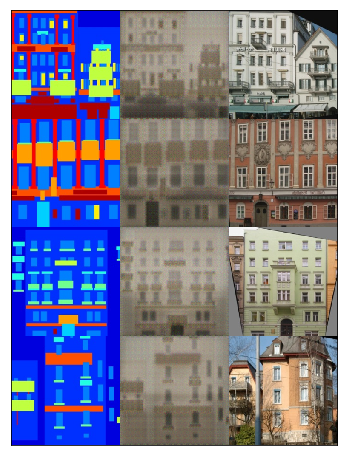

KeyboardInterrupt: 

In [12]:
a.train()